In [25]:
from prophet import Prophet
import pandas as pd
import numpy as np
import tqdm as notebook_tqdm
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid
import tqdm as notebook_tqdm
import plotly.io as pio
pio.renderers.default = "notebook"


In [2]:
df_train = pd.read_csv("../data/Daily Bike Sharing training.csv")
df_future = pd.read_csv("../data/Daily Bike Sharing future.csv")
df = pd.concat([df_train,df_future]).reset_index(drop=True)

In [3]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


In [4]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      701 non-null    float64       
 14  registered  701 non-null    float64       
 15  cnt         701 non-null    float64       
dtypes: datetime64[ns](1), floa

In [6]:
df = df.rename(columns={'cnt':'y',
                        'dteday':'ds'})
df['ds'] = pd.to_datetime(df['ds'],format="%m/%d/%Y")
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


In [7]:
weather_sit = pd.get_dummies(df['weathersit'],drop_first= True)
df = pd.concat([df,weather_sit],axis=1)

In [8]:
df = df.rename(columns={2:'weathersit_2',
                        3:'weathersit_3'})
df.columns

Index(['instant', 'ds', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'y', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [9]:
to_replace =  (df.loc[df.ds == '2012-10-28'].y.values[0])
df.loc[df.ds == '2012-10-29','y'] = to_replace
df.loc[df.ds == '2012-10-30','y'] = to_replace

In [10]:
gen_holidays = pd.DataFrame({'holiday':'gen_holi','ds':df[df.holiday==1].ds,'lower_window': -2, 'upper_window': 2})
xmas = pd.DataFrame({'holiday':'christmas','ds':pd.to_datetime(['2011-12-24','2012-12-24']),'lower_window': -3, 'upper_window': 3})
newyear = pd.DataFrame({'holiday':'new_years','ds':pd.to_datetime(['2011-12-31','2012-12-31']),'lower_window': -3, 'upper_window': 3})


In [11]:
holidays = pd.concat([gen_holidays,xmas,newyear])
holidays

,holiday,ds,lower_window,upper_window
16,gen_holi,2011-01-17,-2,2
51,gen_holi,2011-02-21,-2,2
104,gen_holi,2011-04-15,-2,2
149,gen_holi,2011-05-30,-2,2
184,gen_holi,2011-07-04,-2,2
247,gen_holi,2011-09-05,-2,2
282,gen_holi,2011-10-10,-2,2
314,gen_holi,2011-11-11,-2,2
327,gen_holi,2011-11-24,-2,2
359,gen_holi,2011-12-26,-2,2


In [12]:
lag = 1
df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,weathersit_2,weathersit_3,temp_lag_1
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0,True,False,NaN
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0,True,False,0.344167
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0,False,False,0.363478
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0,False,False,0.196364
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0,False,False,0.200000


In [13]:
df = df.dropna()

In [14]:
train = df.iloc[:-30]
train['ds'].isna().sum()
train.shape

(670, 19)

In [15]:
train['ds'].dtype

dtype('<M8[ns]')

In [16]:
best_params = {'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 20,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [17]:

m = Prophet(holidays = holidays,
            **best_params)
m.add_regressor("workingday")
m.add_regressor("weathersit")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")
m.add_regressor('temp_lag_1')
m.fit(train)

20:58:35 - cmdstanpy - INFO - Chain [1] start processing
20:58:35 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [18]:
future_regressors = df.drop(columns = ['ds','y'])
future_regressors = future_regressors.dropna()
future_regressors.reset_index(drop=True,inplace=True)


In [19]:
future = m.make_future_dataframe(periods=30)
future = future.reset_index(drop=True)
future_regressors = future_regressors.reset_index(drop=True)
future = pd.concat([future, future_regressors], axis=1)


In [20]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,atemp,...,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
695,2012-11-27,6659.283647,4729.957102,6663.513069,6652.281672,6665.442161,-918.745456,-918.745456,-918.745456,-596.705011,...,-87.574777,-87.574777,-87.574777,524.163657,524.163657,524.163657,0.0,0.0,0.0,5740.538191
696,2012-11-28,6667.390735,5675.920376,7593.787089,6659.880280,6674.056956,-28.419365,-28.419365,-28.419365,-572.947577,...,-37.388983,-37.388983,-37.388983,524.163657,524.163657,524.163657,0.0,0.0,0.0,6638.971370
697,2012-11-29,6675.497822,5797.943273,7696.755579,6667.676548,6682.526768,91.077251,91.077251,91.077251,-547.869643,...,141.462069,141.462069,141.462069,524.163657,524.163657,524.163657,0.0,0.0,0.0,6766.575073
698,2012-11-30,6683.604910,6002.181410,7948.412937,6675.402570,6690.968887,286.700822,286.700822,286.700822,-474.185112,...,248.532103,248.532103,248.532103,524.163657,524.163657,524.163657,0.0,0.0,0.0,6970.305732
699,2012-12-01,6691.711997,5433.559458,7311.500954,6682.744414,6699.588070,-276.170868,-276.170868,-276.170868,-494.348814,...,246.217337,246.217337,246.217337,0.000000,0.000000,0.000000,0.0,0.0,0.0,6415.541129


## Data Vizualisations

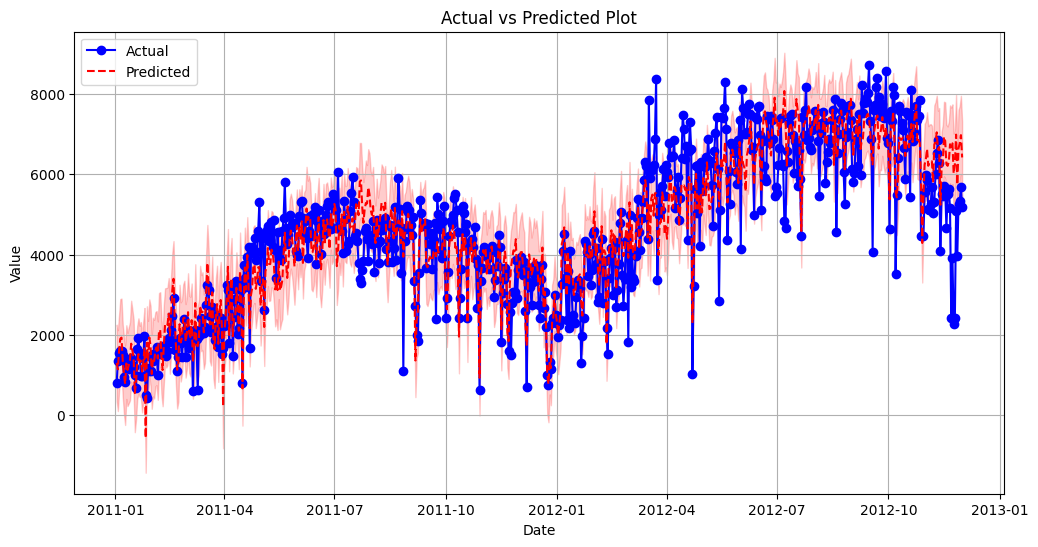

In [30]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='dashed', color='red')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Plot')
plt.legend()
plt.grid(True)
plt.savefig("../visualizations/Forecasting-Visualizations/Actual-VS-Prediction.png")
plt.show()


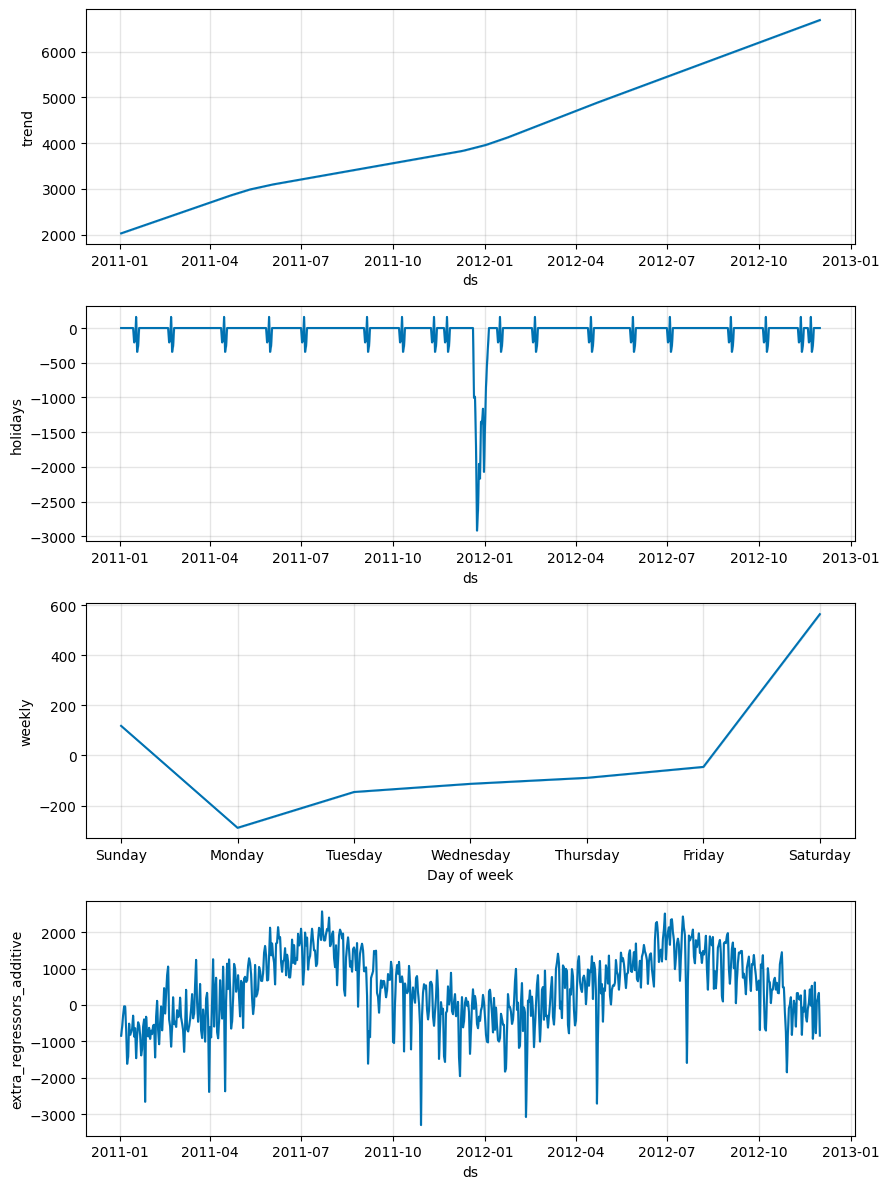

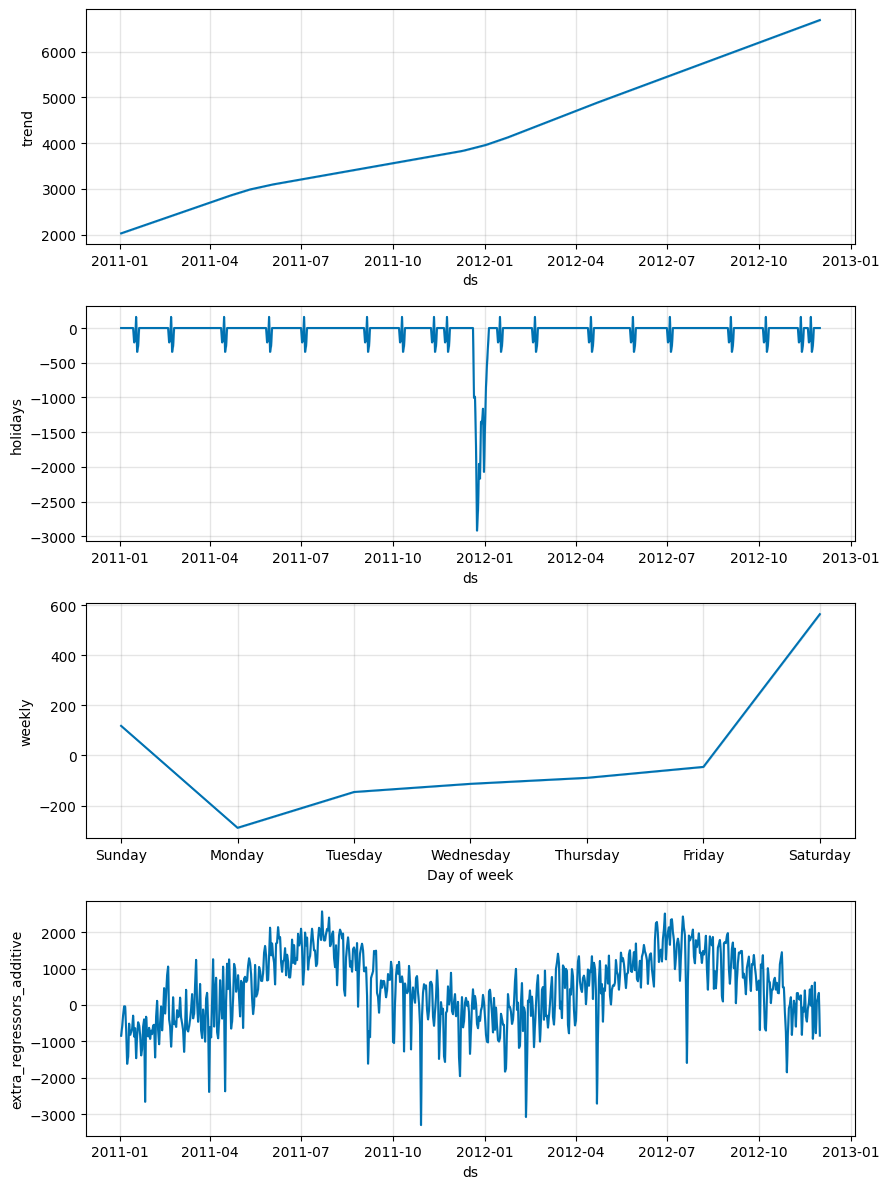

In [31]:
m.plot_components(forecast)
m.plot_components(forecast)
plt.savefig("../visualizations/Forecasting-Visualizations/uncertain_bounds.png")
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]21:09:21 - cmdstanpy - INFO - Chain [1] start processing
21:09:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.23it/s]21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.08it/s]
C:\Users\ANAND REDDY\AppData\Local\Temp\ipykernel_19340\267519625.py:9: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



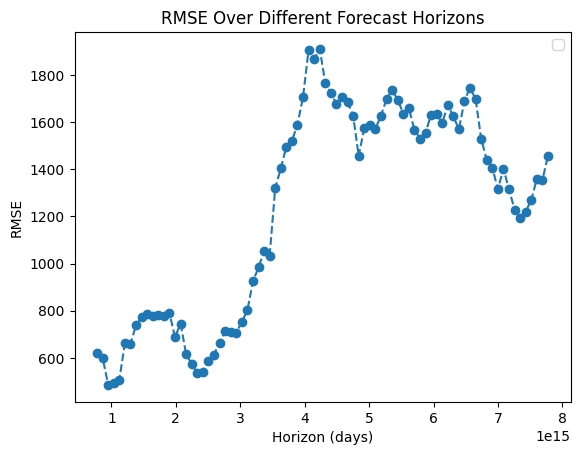

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics  
df_cv = cross_validation(m, initial='365 days', period='180 days', horizon='90 days')  
df_p = performance_metrics(df_cv)  

plt.plot(df_p['horizon'], df_p['rmse'], marker='o', linestyle='dashed')  
plt.xlabel('Horizon (days)')  
plt.ylabel('RMSE')  
plt.title('RMSE Over Different Forecast Horizons')  
plt.show()
